In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import io
import ipywidgets as widgets

from pandas import option_context
from IPython.display import display
from IPython.display import HTML
from ipywidgets import FileUpload

from IPython.display import Javascript
from IPython.display import display_html

# Upload QPix Picking Summary .csv

In [2]:
# Create upload file widget
# Only accept a single CSV file
uploader = widgets.FileUpload(accept='*.csv', multiple=False)
display(uploader)

FileUpload(value={}, accept='*.csv', description='Upload')

In [3]:
# Execute notebook
# https://stackoverflow.com/questions/32714783/ipython-run-all-cells-below-from-a-widget
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run Notebook")
button.on_click(run_all)
display(button)

Button(description='Run Notebook', style=ButtonStyle())

In [5]:
# Display the opened CSV
csv_file = list(uploader.value.values())[0]
csv_content = csv_file['content']
csv_content = io.StringIO(csv_content.decode('utf-8'))

df = pd.read_csv(csv_content, skiprows=11)
df.index += 1
df.head()

,Source Barcode,Source Region,Feature Position X,Feature Position Y,Destination Barcode,Destination Well
1,Auto6378355269472791240,A1,41.7656,27.8115,Auto6378355315410504541,A1
2,Auto6378355269472791240,B1,19.6089,55.2813,Auto6378355315410504541,B1
3,Auto6378355269472791240,C1,26.8465,83.0642,Auto6378355315410504541,C1
4,Auto6378355269472791240,D1,23.8204,111.2010,Auto6378355315410504541,D1
5,Auto6378355269472791240,E1,22.0780,136.3550,Auto6378355315410504541,E1


In [6]:
# DATA CLEANING

# Split Destination Well column into row (letter) and column (number)
df['Source Row'] = df['Source Region'].apply(lambda x: x[0])
df['Source Column'] = pd.to_numeric(df['Source Region'].apply(lambda x: x[1:]))
df['Destination Row'] = df['Destination Well'].apply(lambda x: x[0])
df['Destination Column'] = pd.to_numeric(df['Destination Well'].apply(lambda x: x[1:]))
df = df[['Source Barcode','Source Region','Source Row','Source Column','Destination Barcode',
         'Destination Well','Destination Row','Destination Column','Feature Position X','Feature Position Y']]
df.sort_values('Source Barcode')

# Categorize each Qtray as 1 or 2
qtray_values = df['Source Barcode'].value_counts().sort_values(ascending=True).index.to_list()
if len(qtray_values) > 1:
    qtray_names = [df['Source Barcode'].eq(qtray_values[0]), df['Source Barcode'].eq(qtray_values[1])]
    qtray_numbers = [1, 2]
else:
    qtray_names = [df['Source Barcode'].eq(qtray_values[0])]
    qtray_numbers = [1]
df['Qtray'] = np.select(qtray_names, qtray_numbers, default = 0)

# Reorder column names
df = df[['Source Barcode','Qtray','Source Region','Source Row','Source Column','Destination Barcode',
         'Destination Well','Destination Row','Destination Column','Feature Position X','Feature Position Y']]

In [7]:
# DATA FILTERING

# https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916

# Create a function to find the unique values, sort them, and add them to a list for filtering
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, '')
    unique.insert(1, ALL)
    return unique

# Link two dropdown filters
# Create output object to capture filtered (or unfiltered) dataframes
output = widgets.Output()

# Create dropdown objects for source and destination barcode columns
dropdown_source = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df['Source Barcode']))
dropdown_destination = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df['Destination Barcode']))

# Event handlers for both filters
def common_filtering(source, destination):
    output.clear_output()

    if (source == ALL) & (destination == ALL):
        common_filter = df
    elif (source == ALL):
        common_filter = df[df['Destination Barcode'] == destination]
    elif (destination == ALL):
        common_filter = df[df['Source Barcode'] == source]
    else:
        common_filter = df[(df['Source Barcode'] == source) & (df['Destination Barcode'] == destination)]
    
    with output:
        display(common_filter)

# Event listener functions
def dropdown_source_eventhandler(change):
    common_filtering(change.new, dropdown_destination.value) 
def dropdown_destination_eventhandler(change):
    common_filtering(dropdown_source.value, change.new)

# Event listeners
dropdown_source.observe(dropdown_source_eventhandler, names='value')
dropdown_destination.observe(dropdown_destination_eventhandler, names='value')

print('Select Source Barcode below:')
display(dropdown_source)
print('Select Destination Barcode below:')
display(dropdown_destination)

display(output)

Select Source Barcode below:


Dropdown(options=('', 'ALL', 'Auto6378355269472791240'), value='')

Select Destination Barcode below:


Dropdown(options=('', 'ALL', 'Auto6378355315410504541', 'Auto6378355325394026342', 'Auto6378355335366160713', …

Output()

In [8]:
# number of qtrays
source_df = df['Source Barcode'].value_counts().reset_index()
source_df.index += 1
source_df.columns = ['Source Qtray', 'Picked Features']

# number of features per (source) region per Qtray
temp_source_df = df.groupby(['Source Barcode'])['Source Region'].value_counts()
source_features_df = temp_source_df.to_frame()
source_features_df.columns = ['Picked Features']
source_features_df.sort_index(ascending=True)

destination_df = df['Destination Barcode'].value_counts().reset_index()
destination_df.index += 1
destination_df.columns = ['Destination Plate', 'Deposited Features']

# Picking Overview

In [9]:
# CREATE LABWARE TEMPLATES

# Qtray source plate template
# this layout will be used for the 'Regional Picking' process
rows = ['F','E','D','C','B','A']
qtray_df = pd.DataFrame(index=rows,columns=range(8,0,-1))

# Qtray source plate template FLIPPED
# this layout will be used for the 'Regional Picking with Set Destination' process
rows = ['H','G','F','E','D','C','B','A']
qtray_flipped_df = pd.DataFrame(index=rows,columns=range(6,0,-1))

# Nunc destination plate template
rows = ['A','B','C','D','E','F','G','H']
nunc_plate_df = pd.DataFrame(index=rows,columns=range(1,13))

In [10]:
# Determine which plate template to use
df['Map Source Well to Destination Well'] = df['Source Region'].equals(df['Destination Well'])
map_source_to_dest = df['Map Source Well to Destination Well'].value_counts().index.tolist()

if len(map_source_to_dest) == 1 and map_source_to_dest == True:
    qtray_format = '6rows_8cols'
else:
    qtray_format = '8rows_6cols'
    
# Create dictionaries for holding all plate and well information
source_plate_to_destination_dict = {barcode: nunc_plate_df.copy(deep=True) for barcode in df['Destination Barcode']}
source_well_to_destination_dict = {barcode: nunc_plate_df.copy(deep=True) for barcode in df['Destination Barcode']}
source_plate_feature_dict = {barcode: qtray_df.copy(deep=True) for barcode in df['Source Barcode']}
source_plate_flipped_feature_dict = {barcode: qtray_flipped_df.copy(deep=True) for barcode in df['Source Barcode']}

In [48]:
source_plate_to_destination_dict

{'Auto6378355315410504541':     1    2    3    4    5    6    7    8    9    10   11   12
 A  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 B  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 C  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 D  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 E  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 F  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 G  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 H  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN,
 'Auto6378355325394026342':     1    2    3    4    5    6    7    8    9    10   11   12
 A  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 B  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 C  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 D  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 E  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN


In [11]:
def map_picked_plates_to_nunc(nunc_barcode):
    
    mapping_df = df.loc[df['Destination Barcode'] == nunc_barcode, ['Source Barcode','Qtray','Source Region','Destination Barcode','Destination Well','Destination Row','Destination Column']]
    
    for row, column, qtray in zip(mapping_df['Destination Row'], mapping_df['Destination Column'], mapping_df['Qtray']):
        source_plate_to_destination_dict[nunc_barcode].loc[row][column] = 'Q' + str(qtray)
        source_plate_to_destination_dict[nunc_barcode].fillna('---', inplace=True)
    
    source_plate_to_destination_dict[nunc_barcode].style.set_properties(**{'width-min': '100px', 'text-align':'center'})
    
    return source_plate_to_destination_dict[nunc_barcode]

def map_picked_wells_to_nunc(nunc_barcode):
    
    mapping_df = df.loc[df['Destination Barcode'] == nunc_barcode, ['Source Barcode','Source Region','Destination Barcode','Destination Well','Destination Row','Destination Column']]
    
    for row, column, source_region in zip(mapping_df['Destination Row'], mapping_df['Destination Column'], mapping_df['Source Region']):
        source_well_to_destination_dict[nunc_barcode].loc[row][column] = source_region
        source_well_to_destination_dict[nunc_barcode].fillna('---', inplace=True)
    
    source_well_to_destination_dict[nunc_barcode].style.set_properties(**{'width-min': '100px'})
    
    return source_well_to_destination_dict[nunc_barcode]

def map_picked_from_qtray(qtray_barcode):
    
    mapping_df = df.loc[df['Source Barcode'] == qtray_barcode, ['Source Barcode','Source Region','Source Row','Source Column']]
    
    if qtray_format == '6rows_8cols':
        for row, column, source_barcode, source_region in zip(mapping_df['Source Row'], mapping_df['Source Column'], mapping_df['Source Barcode'], mapping_df['Source Region']):
            source_plate_feature_dict[qtray_barcode].loc[row][column] = source_features_df.loc[(qtray_barcode, source_region)]['Picked Features']
            source_plate_feature_dict[qtray_barcode].fillna(0, inplace=True)
        return source_plate_feature_dict[qtray_barcode]
    
    elif qtray_format == '8rows_6cols':
        for row, column, source_barcode, source_region in zip(mapping_df['Source Row'], mapping_df['Source Column'], mapping_df['Source Barcode'], mapping_df['Source Region']):
            source_plate_flipped_feature_dict[qtray_barcode].loc[row][column] = source_features_df.loc[(qtray_barcode, source_region)]['Picked Features']
            source_plate_flipped_feature_dict[qtray_barcode].fillna(0, inplace=True)
        return source_plate_flipped_feature_dict[qtray_barcode]

In [12]:
# Create more dropdown filters for users to visualize by destination plate

ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, '')
    unique.insert(1, ALL)
    return unique

dropdown_destination_mapping = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df['Destination Barcode']))

output_destination_mapping = widgets.Output()

def dropdown_destination_mapping_eventhandler(change):
    output_destination_mapping.clear_output()
    with output_destination_mapping:
        if (change.new == ALL):
            for plate in source_well_to_destination_dict:
                nunc_source_df_styler = map_picked_plates_to_nunc(plate).style.set_table_attributes("style='display:inline'").set_caption(plate)
                nunc_dest_df_styler = map_picked_wells_to_nunc(plate).style.set_table_attributes("style='display:inline'").set_caption(plate)
                display_html(nunc_source_df_styler._repr_html_() + nunc_dest_df_styler._repr_html_(), raw=True)
                print("+"*43)
        else:
            #display(df[df['Destination Barcode'] == change.new])
            nunc_source_df_styler = map_picked_plates_to_nunc(change.new).style.set_table_attributes("style='display:inline'").set_caption(change.new)
            nunc_dest_df_styler = map_picked_wells_to_nunc(change.new).style.set_table_attributes("style='display:inline'").set_caption(change.new)
            display_html(nunc_source_df_styler._repr_html_() + nunc_dest_df_styler._repr_html_(), raw=True)

print("Select Destination Barcode Mapping below:")
dropdown_destination_mapping.observe(dropdown_destination_mapping_eventhandler, names='value')
display(dropdown_destination_mapping)
display(output_destination_mapping)

Select Destination Barcode Mapping below:


Dropdown(options=('', 'ALL', 'Auto6378355315410504541', 'Auto6378355325394026342', 'Auto6378355335366160713', …

Output()

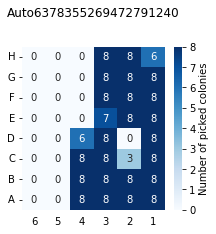

In [13]:
if len(qtray_values) > 1:
    plt.subplots(1, 2, figsize=(8, 3))
    current_qtray = 1

    for qtray in source_plate_feature_dict:
        plt.subplot(1, 2, current_qtray)
        plt.title(qtray, pad='30')
        plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=False, top=False)
        sns.heatmap(map_picked_from_qtray(qtray), annot=map_picked_from_qtray(qtray), cmap='Blues',
                         cbar_kws={'label': 'Number of picked colonies'})
        plt.yticks(rotation=0)
        current_qtray += 1

    plt.subplots_adjust(wspace=0.5)
    
else:
    plt.subplots(1, figsize=(8, 3))
    current_qtray = 1

    for qtray in source_plate_feature_dict:
        plt.subplot(1, 2, current_qtray)
        plt.title(qtray, pad='30')
        plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=False, top=False)
        sns.heatmap(map_picked_from_qtray(qtray), annot=map_picked_from_qtray(qtray), cmap='Blues',
                         cbar_kws={'label': 'Number of picked colonies'})
        plt.yticks(rotation=0)

    plt.subplots_adjust(wspace=0.5)
    

# Summary

In [14]:
# total number of features picked
total_features_picked = len(df)
print(f'{total_features_picked} features picked')

# summary of picked and deposited
display(source_df)
display(destination_df)

206 features picked


,Source Qtray,Picked Features
1,Auto6378355269472791240,206


,Destination Plate,Deposited Features
1,Auto6378355315410504541,27
2,Auto6378355325394026342,27
3,Auto6378355335366160713,27
4,Auto6378355345316098514,26
5,Auto6378355355282036205,26
6,Auto6378355365158503236,26
7,Auto6378355375033989307,24
8,Auto6378355384788686078,23
